In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy
import scipy.spatial.distance

#from gimutil.visualization import plotting_tools
from gimutil_plotting import setup_figure
import seaborn as sns
import matplotlib.font_manager
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

# Define the POA category mappings
poa_map = {
    'Labial'      : ['B', 'P', 'M', 'F', 'V', 'W'], 
    'Front tongue'    : ['T', 'D', 'S', 'Z', 'N', 'L', 'R'] + ['SH', 'CH', 'JH'] + ['TH', 'DH'] , 
    'Back tongue'     :['K', 'G', 'NG'],
    'Vocalic' : ['IH', 'EH', 'AE'] +['AH', 'ER']+['AA'] + ['UH', 'UW','AW', 'OW','AO']
}

  
# convert from the text labels to more formal IPA
text_to_ipa = {'-': 'Ø',
 '|': 'Ø',
 'AA': 'ɑ',
 'AE': 'æ',
 'AH': 'ʌ',
 'AO': 'ɔ',
 'AW': 'aʊ',
 'AY': 'aɪ',
 'B': 'b',
 'CH': 'tʃ',
 'D': 'd',
 'DH': 'ð',
 'EH': 'ɛ',
 'ER': 'ɝ',
 'EY': 'eɪ',
 'F': 'f',
 'G': 'ɡ',
 'HH': 'h',
 'IH': 'ɪ',
 'IY': 'i',
 'JH': 'dʒ',
 'K': 'k',
 'L': 'l',
 'M': 'm',
 'N': 'n',
 'NG': 'ŋ',
 'OW': 'oʊ',
 'OY': 'ɔɪ',
 'P': 'p',
 'R': 'ɹ',
 'S': 's',
 'SH': 'ʃ',
 'T': 't',
 'TH': 'θ',
 'UH': 'ʊ',
 'UW': 'u',
 'V': 'v',
 'W': 'w',
 'Y': 'j',
 'Z': 'z',
 'ZH': 'ʒ'}
### Excluding H because it isn't one of 4 categories to focus on 


# key is phone label, value is the artic feature
inverse_poa_map = {}
for cur_poa_set_name, cur_phone_list in poa_map.items():
    for cur_phone in cur_phone_list:
        inverse_poa_map[cur_phone] = cur_poa_set_name
        

# load the grid layout
with open('./b3_layout.pkl','rb') as f:
    elec_layout = pickle.load(f)
two_d_coords = np.zeros((253,3))
ind = 0
for c in range(elec_layout.shape[1]):
    for i,r in enumerate(range(elec_layout.shape[0])):
        two_d_coords[ind,:] = [c,-i,elec_layout[r,c]]
        ind += 1
two_d_coords = two_d_coords[two_d_coords[:, 2].argsort(),:]
    
#load up the final data (some stuff like the dendrograms must be computed from this and was not able to be saved to source data)
# path to the final weights
path = './final_emiss_mdl_02r.pkl'
with open(path,'rb') as f:
    df = pickle.load(f)

labels = list(df.columns)
HH_ind = labels.index('HH')
labels.pop(HH_ind)
data = df.values[:]
data = np.delete(data, HH_ind, 1)    
sig_elecs_inds_on_grid = df.index.values  



# load the source data for each panel 
panel_b = pd.read_excel('./fig5_sourcedata.xlsx',engine='openpyxl',sheet_name='Panel_b')
panel_c = pd.read_excel('./fig5_sourcedata.xlsx',engine='openpyxl',sheet_name='Panel_c')
panel_d = pd.read_excel('./fig5_sourcedata.xlsx',engine='openpyxl',sheet_name='Panel_d').iloc[:,1:]
panel_e = pd.read_excel('./fig5_sourcedata.xlsx',engine='openpyxl',sheet_name='Panel_e').iloc[:,1:]
panel_f = pd.read_excel('./fig5_sourcedata.xlsx',engine='openpyxl',sheet_name='Panel_f').iloc[:,1:]
panel_g = pd.read_excel('./fig5_sourcedata.xlsx',engine='openpyxl',sheet_name='Panel_g').iloc[:,1:]
panel_h = pd.read_excel('./fig5_sourcedata.xlsx',engine='openpyxl',sheet_name='Panel_h').iloc[:,1:]
panel_i = pd.read_excel('./fig5_sourcedata.xlsx',engine='openpyxl',sheet_name='Panel_i').iloc[:,1:]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


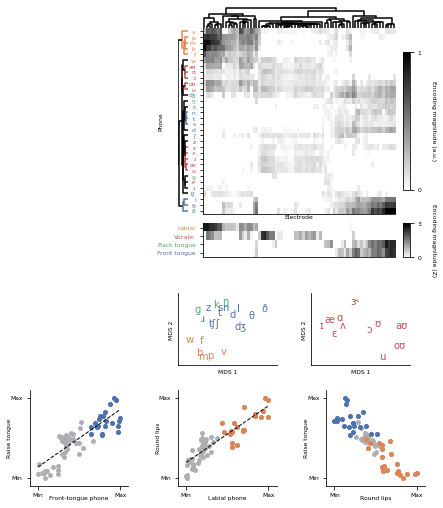

In [2]:
# first we need to set up the figure 
# defining the plotting parameters
rows = {
    'dend_start' : 5,
    'dend_stop'  : 50,
    'main_start' : 50,
    'main_stop'  : 435,
    'maincbar_start':100,
    'maincbar_stop': 385,
    'poa_start'  : 455,
    'poa_stop'   : 525,
    'consmds_start'   : 600,
    'consmds_stop'   : 750,
    'vowelmds_start'   : 600,
    'vowelmds_stop'   : 750,
    'motor_start' : 800,
    'motor_stop' : 1000,
    'grid_start' : 300,
    'grid_stop' : 650,
    'histx_start' :250,
    'histx_stop' : 300,
    'total'      : 1000,
}
cols = {
    'dend_start' : 300,
    'dend_stop'  : 320,
    'main_start' : 350,
    'main_stop'  : 740,
    'cbar_start' : 755,
    'cbar_stop'  : 770,
    'consmds_start'   : 300,
    'consmds_stop'   : 500,
    'vowelmds_start'   : 570,
    'vowelmds_stop'   : 770,
    'hand_start' : 0,
    'hand_stop' : 200,
    'lips_start' : 300,
    'lips_stop' : 500, 
    'tongue_start' : 600,
    'tongue_stop' : 800,  
    'grid_start': 20,
    'grid_stop' : 150,
    'histy_start': 0,
    'histy_stop' : 20,
    'total'      : 800
}
all_panel_params = {
    'elec_clusters' : {'row_and_col_spec' : ('dend', 'main')},
    'phone_clusters'  : {'row_and_col_spec' : ('main', 'dend')},
    'main'           : {'row_and_col_spec' : ('main', 'main')},
    'cbar'           : {'row_and_col_spec' : ('maincbar', 'cbar')},
    'poa'            : {'row_and_col_spec' : ('poa',  'main')},
    'poa_cbar'       : {'row_and_col_spec' : ('poa', 'cbar')},
    'vowel_mds'       : {'row_and_col_spec' : ('vowelmds', 'vowelmds')},
    'cons_mds'       : {'row_and_col_spec' : ('consmds', 'consmds')},
    'tongue'       : {'row_and_col_spec' : ('motor', 'hand')},
    'lips'       : {'row_and_col_spec' : ('motor', 'lips')},
    'cross'       : {'row_and_col_spec' : ('motor', 'tongue')}

}


# colors for each POA
a = sns.color_palette("deep")
hex_col = a.as_hex()
poa_colors = {
    'Labial'      : hex_col[1],
    'Front tongue'    : hex_col[0],
    'Back tongue'     : hex_col[2],
    'Vocalic'   : hex_col[3]
}

# Font and size 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams.update({'font.size': 6})

# Sets up the phone coloring
phone_colors = {
    cur_phone : poa_colors[cur_poa_set_name]
    for cur_phone, cur_poa_set_name in inverse_poa_map.items()
}

# Creates the plot plotting_tools.
scale = 18/2.54
fig, axs = setup_figure(
    all_panel_params=all_panel_params, row_specs=rows, col_specs=cols,
    figsize=(scale, scale*1.25) #10,13
)





# Compute and plot the dendrograms for phones and electrodes
ax = axs['elec_clusters']

# computing for electrodes from the raw data
Z = scipy.cluster.hierarchy.linkage(data, method='centroid', optimal_ordering=True)
dend = scipy.cluster.hierarchy.dendrogram(
    Z, ax=ax, no_labels=True, color_threshold=0.,
    link_color_func=(lambda k: 'black')
)
ax.axis('off')
new_row_order = [int(i) for i in dend['ivl']]

# computing for phones from the raw data
Z = scipy.cluster.hierarchy.linkage(data.T, method='centroid', optimal_ordering=True)

leaf_cols = {}
for i,lab in enumerate(labels):
    leaf_cols[i] = poa_colors[inverse_poa_map[lab]]

# coloring the leaves of the dendrogram based on POA
ax = axs['phone_clusters']
colors = {}
colors[0] = poa_colors['Front tongue']
colors[1] = poa_colors['Labial']
colors[2] = poa_colors['Back tongue']

link_cols = {}
for i, i12 in enumerate(Z[:,:2].astype(int)):
  c1,c2 = (link_cols[x] if x > len(Z) else leaf_cols[x]
    for x in i12)
  link_cols[i+1+len(Z)] = c1 if c1 == c2 else 'black'

# ploting for the phones 
dend = scipy.cluster.hierarchy.dendrogram(
    Z, labels=range(0,len(labels)),orientation='left', ax=ax,color_threshold=None, above_threshold_color='grey', link_color_func=(lambda k: link_cols[k])
)
ax.invert_yaxis()
ax.axis('off')

# few helpful variables that reflect the clustered phone and electrode order (corresponds to the order of source data for panel b)
labels = np.array(labels)
new_col_order = labels[np.array(dend['ivl']).astype(int)]
labels= list(labels)
new_col_index = [labels.index(i) for i in new_col_order]

# Plots the encodings from source data
ax = axs['main']

encodings_plot = ax.matshow(panel_b.iloc[:,1:], cmap='binary', vmin=0., vmax=1., aspect='auto')
ipa_col_labs = [text_to_ipa[i] for i in panel_b.iloc[:,0].to_numpy()]

ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)

ax.tick_params(axis='y', which='minor', length=0, pad=0.05)
ax.set_yticks(np.arange(panel_b.shape[0]))
ax.set_yticklabels(panel_b.iloc[:,0])


# set the colors of ticks to be by POA
cats_final = []
all_cols = []
for cur_label in ax.get_yticklabels():
    cur_label.set_color(phone_colors[cur_label.get_text()])
    all_cols.append(phone_colors[cur_label.get_text()])
    cats_final.append(inverse_poa_map[cur_label.get_text()])
ax.xaxis.set_ticks([])
ax.set_xlabel('Electrode', rotation=0, labelpad=1.)
ax.set_yticklabels(ipa_col_labs[::-1][::-1])
ax.set_ylabel('Phone',labelpad=25.)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)


# Plots the colorbar
ax = axs['cbar']
cbar_ticks = [0., 1.]
cbar = fig.colorbar(encodings_plot, cax=ax, ticks=cbar_ticks)
cbar.ax.set_ylim(cbar_ticks[0], cbar_ticks[-1])
cbar.set_label('Encoding magnitude (a.u.)', rotation=270, labelpad=15.)
ax.yaxis.set_ticks_position('right')

# Plots the average z-scored signal over each POA feature 
ax = axs['poa']
enc_vecs = []
cats_final = np.array(cats_final)
uni_cats = np.unique(cats_final)[[2,3,0,1]] # want this in the same order as the main encodings

# Plot panel c from source 
cat_means = ax.matshow(panel_c.iloc[:,1:], cmap='binary', vmin=0, vmax=3, aspect='auto')
ax.tick_params(axis='y', which='minor', length=0, pad=0.05)
ax.set_yticks(np.arange(len(uni_cats)))
ax.set_yticklabels(uni_cats) 
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
for cur_label in ax.get_yticklabels():
    cur_label.set_color(poa_colors[cur_label.get_text()])
ax.xaxis.set_ticks([])


# Plots the colorbar for the feature encoder 
ax = axs['poa_cbar']
cbar_ticks = [0., 3.]
cbar = fig.colorbar(cat_means, cax=ax, ticks=cbar_ticks)
cbar.ax.set_ylim(cbar_ticks[0], cbar_ticks[-1])
cbar.set_label('Encoding magnitude (Z)', rotation=270, labelpad=15.)
ax.yaxis.set_ticks_position('right')


### Now creating MDS plots 

# split by vowel and consonant 
all_cols  = np.array(all_cols)
is_vowel = np.logical_or(cats_final == 'Vocalic', cats_final == 'rounded vowel')

# convert to ipa labels
ipa_labs = np.array(ipa_col_labs)[np.logical_not(is_vowel)]
cons_cols = all_cols[np.logical_not(is_vowel)]

# plot the consonants from source
ax = axs['cons_mds']
for i,row in panel_d.iterrows(): #enumerate(x_pc): 
    ax.text(row.MDS1, row.MDS2, row.label, fontsize=10,color=cons_cols[i])
sns.despine()
ax.set_xlim([-.1,1.2])
ax.set_ylim([-.1, 1.2])
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('MDS 2')
ax.set_xlabel('MDS 1')

# plot the vowels from source 
ax = axs['vowel_mds']
vowel_cols = all_cols[(is_vowel)]
for i,row in panel_e.iterrows():
    ax.text(row.MDS1, row.MDS2, row.label, fontsize=10,color=vowel_cols[i])
sns.despine()
ax.set_xlim([-.1,1.2])
ax.set_ylim([-.1, 1.2])
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('MDS 2')
ax.set_xlabel('MDS 1')

### now plot the motor scatter plots 

# get the top electrodes for each POA category
elec_ids = sig_elecs_inds_on_grid[new_row_order]
coronal_inds = [np.where(elec_ids == c)[0][0] for c in panel_f.top_coronal.to_numpy()]
labial_inds = [np.where(elec_ids == c)[0][0] for c in panel_f.top_lips.to_numpy()]
vocalic_inds = [np.where(elec_ids == c)[0][0] for c in panel_f.top_vocalic.to_numpy()]

# plot the tongue attempted movement vs phone scatterplot 
ax = axs['tongue']
ax.scatter(panel_g['Front-tongue phone'],panel_g['Raise tongue'],color='#ADAEB2',s=15)
ax.scatter(panel_g['Front-tongue phone'].iloc[coronal_inds],panel_g['Raise tongue'].iloc[coronal_inds],color=poa_colors['Front tongue'],s=15)
ax.set_xlabel('Front-tongue phone',labelpad=-2)
ax.set_ylabel('Raise tongue',labelpad=-2)
ax.set_yticks([0,.4,.8])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([0,1])
ax.set_yticklabels(['Min','Max'])
ax.set_xticks([0,1])
ax.set_xticklabels(['Min','Max'])

# fit the regression models
model = LinearRegression()
model.fit(panel_g['Front-tongue phone'].to_numpy().reshape(-1, 1), panel_g['Raise tongue'].to_numpy().reshape(-1, 1))
x_new = np.linspace(0, 1, 100)
y_new = model.predict(x_new[:, np.newaxis])
ax.plot(x_new, y_new,color='k',linewidth=1,linestyle='--',zorder=1)
ax.set_xlim([-0.1,1.1])
ax.set_ylim([-0.1,1.1])

# plot the lips attempted movement vs labial scatterplot 
ax = axs['lips']
ax.scatter(panel_h['Labial phone'],panel_h['Round lips'],color='#ADAEB2',s=15)
ax.scatter(panel_h['Labial phone'].iloc[labial_inds],panel_h['Round lips'].iloc[labial_inds],color=poa_colors['Labial'],s=15)
ax.set_xlabel('Labial phone',labelpad=-2)
ax.set_ylabel('Round lips',labelpad=-2)
ax.set_yticks([0,1])
ax.set_yticklabels(['Min','Max'])
ax.set_xticks([0,1])
ax.set_xticklabels(['Min','Max'])

# fit the regression models
model = LinearRegression()
model.fit(panel_h['Labial phone'].to_numpy().reshape(-1, 1), panel_h['Round lips'].to_numpy().reshape(-1, 1))
x_new = np.linspace(0, 1, 100)
y_new = model.predict(x_new[:, np.newaxis])
ax.plot(x_new, y_new,color='k',linewidth=1,linestyle='--',zorder=1)
ax.set_xlim([-0.1,1.1])
ax.set_ylim([-0.1,1.1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plot the lips attempted movement vs tongue attempted movement scatterplot 
ax = axs['cross']
i =0 
fig.subplots_adjust(wspace=0.4)
ax.scatter(panel_i['Round lips'],panel_i['Raise tongue'],color='#ADAEB2',s=15)
ax.scatter(panel_i['Round lips'].iloc[labial_inds],panel_i['Raise tongue'].iloc[labial_inds],color=poa_colors['Labial'],s=15)
ax.scatter(panel_i['Round lips'].iloc[coronal_inds],panel_i['Raise tongue'].iloc[coronal_inds],color=poa_colors['Front tongue'],s=15)
ax.set_xlabel('Round lips',labelpad=-2)
ax.set_ylabel('Raise tongue',labelpad=-2)
ax.set_xlim([-0.1,1.1])
ax.set_ylim([-0.1,1.1])
ax.set_yticks([0,1])
ax.set_yticklabels(['Min','Max'])
ax.set_xticks([0,1])
ax.set_xticklabels(['Min','Max'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# show the plot
plt.show()

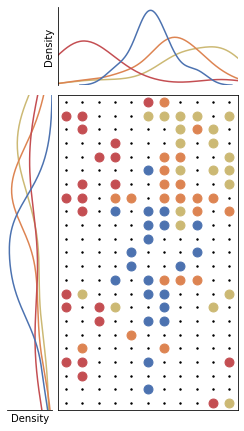

In [3]:
# Now we will plot the somatotopy on the grid

# increase the font a bit 
plt.rcParams.update({'font.size': 10})

# get the two-d distributions for each category 
lab_dists = two_d_coords[panel_f['top_lips'],0:2]
vowel_dists = two_d_coords[panel_f['top_vocalic'] ,0:2]
hand_dists = two_d_coords[panel_f['top_hand'],0:2]
coronal_dists = two_d_coords[panel_f['top_coronal'],0:2]

# define the electrodes corresponding to each cluster 
hand_clust = panel_f['top_hand']
lips_clust = panel_f['top_lips']
coronal_clust = panel_f['top_coronal']
vowel_clust = panel_f['top_vocalic']


# Start with a square Figure.
fig = plt.figure(figsize=(4, 7))

# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(1, 4), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

# Create the Axes.
ax = fig.add_subplot(gs[1, 1])
ax_histx = fig.add_subplot(gs[0, 1], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 0], sharey=ax)


# core scatter plot of the electrodes with color by whether they are in top for an artic cluster
ax.scatter(two_d_coords[:,0],two_d_coords[:,1],color='k',s=2)
ax.scatter(two_d_coords[hand_clust,0],two_d_coords[hand_clust,1],color=hex_col[-2],s=80)
ax.scatter(two_d_coords[lips_clust,0],two_d_coords[lips_clust,1],color=poa_colors['Labial'],s=80)
ax.scatter(two_d_coords[coronal_clust,0],two_d_coords[coronal_clust,1],color=poa_colors['Front tongue'],s=80)
ax.scatter(two_d_coords[vowel_clust,0],two_d_coords[vowel_clust,1],color=poa_colors['Vocalic'],s=80)
ax.set_ylim([-22.5,0.5])
ax.set_xlim([-0.5,10.5])

# Making the x-dimension (ant-post) marginal densities 
sns.kdeplot(x=hand_dists[:,0],color=hex_col[-2],ax=ax_histx)
sns.kdeplot(x=lab_dists[:,0],color=poa_colors['Labial'],ax=ax_histx)
sns.kdeplot(x=vowel_dists[:,0],color=poa_colors['Vocalic'],ax=ax_histx)
sns.kdeplot(x=coronal_dists[:,0],color=poa_colors['Front tongue'],ax=ax_histx)
ax_histx.spines['top'].set_visible(False)
ax_histx.spines['right'].set_visible(False)
ax_histx.spines['bottom'].set_visible(False)
ax_histx.set_yticks([])
ax_histx.set_xticks([])

ax_histx.set_ylabel('Density')


# Making the y-dimension (ventral-dorsal) marginal densities 
sns.kdeplot(y=hand_dists[:,1],color=hex_col[-2], ax=ax_histy)
sns.kdeplot(y=lab_dists[:,1],color=poa_colors['Labial'],ax=ax_histy)
sns.kdeplot(y=vowel_dists[:,1],color=poa_colors['Vocalic'],ax=ax_histy)
sns.kdeplot(y=coronal_dists[:,1],color=poa_colors['Front tongue'],ax=ax_histy)
ax_histy.spines['top'].set_visible(False)
ax_histy.spines['right'].set_visible(False)
ax_histy.spines['left'].set_visible(False)
ax_histy.invert_xaxis()
ax_histy.set_xticks([])
ax_histy.set_yticks([])
ax_histy.set_xlabel('Density')

#show the plot 
plt.show()